# Práctica 2 - Visualización

### Patricia Córdoba Hidalgo

Importamos las librerías que usaremos.

In [237]:
import pandas as pd
import numpy as np
import math as m

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from sklearn import tree

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from sklearn import metrics
import seaborn as sns

## Eliminación de atributo no predictivo y cuantificar las columnas categóricas

In [238]:
datos = pd.read_csv("mamografias.csv", na_values=["?"]) # Leemos los datos del csv

Convertimos los atributos categóricos en numéricos:

In [239]:
# Creamos un objeto Labelencoder
le = preprocessing.LabelEncoder()
# Convertimos las columnas categóricas en numéricas
encoded_value = le.fit_transform(["R","O","L","I", "N"])

for col in ['Shape']:
    datos[col] = le.fit_transform(datos[col])
    
print(encoded_value)

[4 3 1 0 2]


In [240]:
# Creamos un objeto Labelencoder
le = preprocessing.LabelEncoder()
# Convertimos las columnas categóricas en numéricas
encoded_value = le.fit_transform(["maligno", "benigno"])

for col in ['Severity']:
    datos[col] = le.fit_transform(datos[col])

print(encoded_value)

[1 0]


Eliminamos la columna BI-RADS, que no es predictiva.

In [241]:
del(datos['BI-RADS'])

## Preprocesado 1:

Eliminamos los datos con valores perdidos.

In [242]:
p1_datos = datos.dropna() # Eliminamos los datos con valores perdidos

Ya no hay datos "perdidos".

### Separación entre datos y objetivo

In [243]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p1_datos.columns if col not in ['Severity']]
data = p1_datos[cols]
target = p1_datos['Severity']

In [244]:
# Mostramos si los datos están o no balanceados (Para ver si accuracy es una buena medida)
malignos = 0
for i in target:
    if i == 1:
        malignos += 1

benignos = len(target) - malignos
print("Hay " + str(malignos) + " malignos y " + str(benignos) + " benignos.")

Hay 410 malignos y 438 benignos.


### Modelos:

In [245]:
def validacion_cruzada(clf, x, y, n):
    tn, tp, fn, fp = 0,0,0,0
    scaler = MinMaxScaler()

    # Creo los n conjuntos diferentes
    l = len(x)
    l = int(l/n)

    datos = []               #Vector de datos para training de cada iteración
    im_datos = []            #Vector de etiquetas para training de cada iteración
    datos_val = []           #Vector de datos para validación de cada iteración
    im_datos_val = []        #Vector de etiquetas para validación de cada iteración

    for i in range(0,n-1):
        aux_x = np.concatenate((x[:i*l], x[(i+1)*l:]), axis=0)
        aux_y = np.concatenate((y[:i*l], y[(i+1)*l:]), axis=0)
        
        datos.append(aux_x) #Valores de entrenamiento
        im_datos.append(aux_y)
        datos_val.append(x[i*l:(i+1)*l]) #Valores de validación
        im_datos_val.append(y[i*l:(i+1)*l])  
        
    #Última iteración, para usar todos los datos del test
    aux_x = x[:(n-1)*l]
    aux_y = y[:(n-1)*l]
        
    datos.append(aux_x) #Valores de entrenamiento
    im_datos.append(aux_y)
    datos_val.append(x[(n-1)*l:]) #Valores de validación
    im_datos_val.append(y[(n-1)*l:])
        
    # Realizo el ajuste con todos los conjuntos
    for i in range(0,n):
        datos[i] = scaler.fit_transform(datos[i])
        datos_val[i] = scaler.transform(datos_val[i])
        
        clf.fit(datos[i], im_datos[i])
        pred = clf.predict(datos_val[i])
        
        conf_mat = confusion_matrix(im_datos_val[i],pred)
        tn += conf_mat[0,0]
        tp += conf_mat[1,1]
        fn += conf_mat[1,0]
        fp += conf_mat[0,1]

    return tn, tp, fn, fp

In [246]:
# Vectores de medidas de los distintos preprocesados
p1_acc = []
p1_tpr = []
p1_fnr = []
p1_f1 = []

### ZeroR: 

In [247]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### Support Vector Machine (SVM):

In [248]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### k-nn:

In [249]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### Árbol de decisión:

In [250]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### Multilayer Perceptron (neural networks):

In [251]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### Random Forest:

In [252]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p1_acc.append(accuracy)
p1_tpr.append(tpr)
p1_fnr.append(fnr)
p1_f1.append(f1)

### Visualización de métricas:

Text(0.5, 1.0, 'P1 - Accuracy')

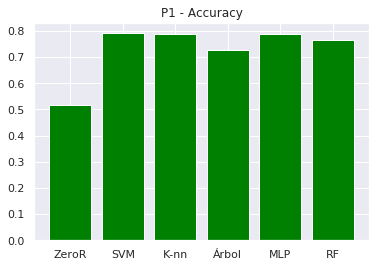

In [253]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p1_acc, color='green')
ax.set_title("P1 - Accuracy")

Text(0.5, 1.0, 'P1 - F1-Score')

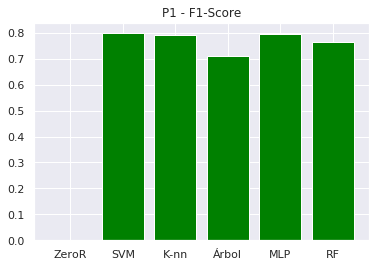

In [254]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p1_f1, color='green')
ax.set_title("P1 - F1-Score")

Text(0.5, 1.0, 'P1 - TPR')

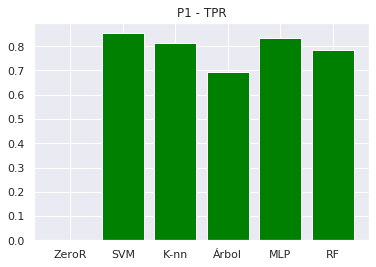

In [255]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p1_tpr, color='green')
ax.set_title("P1 - TPR")

Text(0.5, 1.0, 'P1 - FNR')

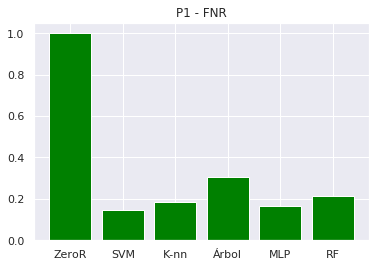

In [256]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p1_fnr, color='green')
ax.set_title("P1 - FNR")

## Preprocesado 2:

Sustituimos los valores perdidos por la mediana si es cuantitativo y por la moda si es cualitativo.

In [257]:
p2_datos = datos.copy()

Para realizar operaciones con las columnas, como calcular la media, necesito que los datos sean de tipo numérico, por eso los cambiamos con astype al hacerlo.

In [258]:
# Rellenaremos los valores perdidos de Age con la mediana:
p2_datos[["Age"]] = p2_datos[["Age"]].fillna(int(p2_datos[["Age"]].median()))
print("Mediana de la edad: " + str(int(p2_datos[["Age"]].median())))

# Rellenaremos los valores perdidos de Margin con la moda:
p2_datos[["Margin"]] = p2_datos[["Margin"]].fillna(datos[["Margin"]].mode().iloc[0,0])
print("Moda del margen: " + str(p2_datos[["Margin"]].mode().iloc[0,0]))

# Rellenaremos los valores perdidos de Shape con la moda:
p2_datos[["Density"]] = p2_datos[["Density"]].fillna(p2_datos[["Density"]].mode().iloc[0,0])
print("Moda de la densidad: " + str(p2_datos[["Density"]].mode().iloc[0,0]))

Mediana de la edad: 57
Moda del margen: 1.0
Moda de la densidad: 3.0


### Separación entre datos y objetivo:

In [259]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p2_datos.columns if col not in ['Severity']]
data = p2_datos[cols]
target = p2_datos['Severity']

In [260]:
# Creamos los vectores que usaremos para visualizar los datos
p2_acc = []
p2_tpr = []
p2_fnr = []
p2_f1 = []

### Desempeño:

#### ZeroR:

In [261]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

#### Support Vector Machine (SVM):

In [262]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

#### K-nn:

In [263]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

#### Árbol de decisión:

In [264]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

#### Multilayer Perceptron (MLP):

In [265]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

#### Random Forest (RF):

In [266]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p2_acc.append(accuracy)
p2_tpr.append(tpr)
p2_fnr.append(fnr)
p2_f1.append(f1)

### Visualización de métricas

Text(0.5, 1.0, 'P2 - Accuracy')

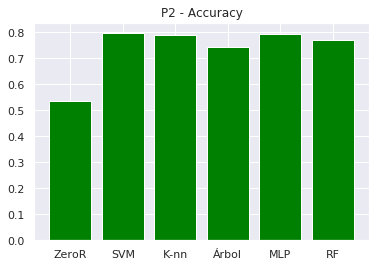

In [267]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p2_acc, color='green')
ax.set_title("P2 - Accuracy")

Text(0.5, 1.0, 'P2- F1-Score')

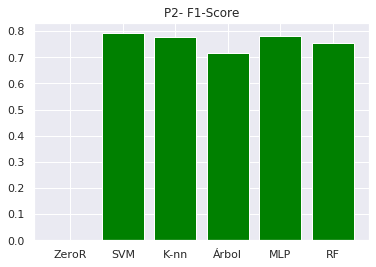

In [268]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p2_f1, color='green')
ax.set_title("P2- F1-Score")

Text(0.5, 1.0, 'P2 - TPR')

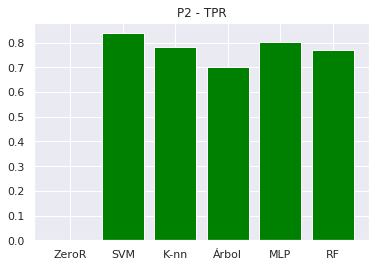

In [269]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p2_tpr, color='green')
ax.set_title("P2 - TPR")

Text(0.5, 1.0, 'P2 - FNR')

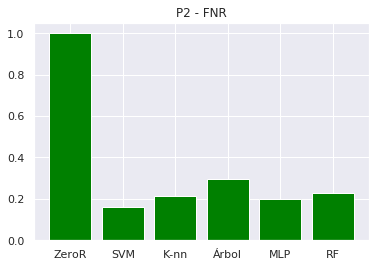

In [270]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p2_fnr, color='green')
ax.set_title("P2 - FNR")

## Preprocesado 3:

Eliminamos la característica Densidad por su baja varianza y eliminamos los datos con valores perdidos.

In [271]:
p3_datos = datos.copy()

In [272]:
del(p3_datos['Density'])

In [273]:
p3_datos = p3_datos.dropna()

### Separación entre datos y objetivo

In [274]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p3_datos.columns if col not in ['Severity']]
data = p3_datos[cols]
target = p3_datos['Severity']

In [275]:
# Mostramos si los datos están o no balanceados (Para ver si accuracy es una buena medida)
malignos = 0
for i in target:
    if i == 1:
        malignos += 1

benignos = len(target) - malignos
print("Hay " + str(malignos) + " malignos y " + str(benignos) + " benignos.")

Hay 429 malignos y 479 benignos.


### Modelos:

In [276]:
# Creamos los vectores que usaremos para visualizar los datos
p3_acc = []
p3_tpr = []
p3_fnr = []
p3_f1 = []

### ZeroR:

In [277]:
dummy_clf = DummyClassifier(strategy="most_frequent")

tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### Support Vector Machine (SVM):

In [278]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)

tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### k-nn:

In [279]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### Árbol de decisión:

In [280]:
tree_clf = DecisionTreeClassifier(random_state=15)

tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### Multilayer Perceptron (MLP):

In [281]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)

tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### Random Forest (RF):

In [282]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)

tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

accuracy = (tn+tp)/(tn+tp+fn+fp)
tpr = tp/(tp+fn)
fnr = fn/(tp+fn)
f1 = (2*tp)/(2*tp+fp+fn)

p3_acc.append(accuracy)
p3_tpr.append(tpr)
p3_fnr.append(fnr)
p3_f1.append(f1)

### Visualizando las métricas

Text(0.5, 1.0, 'P3 - Accuracy')

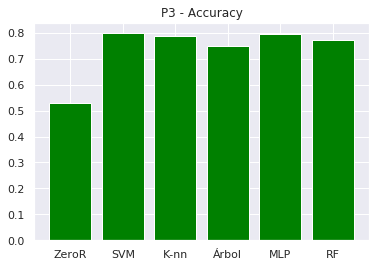

In [283]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p3_acc, color='green')
ax.set_title("P3 - Accuracy")

Text(0.5, 1.0, 'P3 - F1-Score')

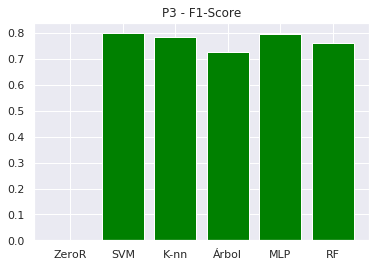

In [284]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p3_f1, color='green')
ax.set_title("P3 - F1-Score")

Text(0.5, 1.0, 'P3 - TPR')

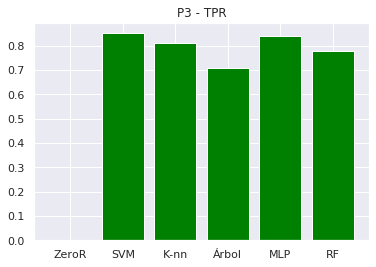

In [285]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p3_tpr, color='green')
ax.set_title("P3 - TPR")

Text(0.5, 1.0, 'P3 - FNR')

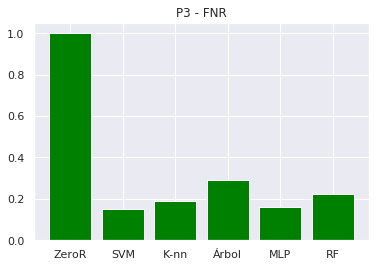

In [286]:
fig, ax = plt.subplots()
ax.bar(["ZeroR", "SVM", "K-nn", "Árbol", "MLP", "RF"], p3_fnr, color='green')
ax.set_title("P3 - FNR")

##### Comparación de cada modelo:

In [287]:
# Vectores con F1-Score de cada modelo
v_zeror = [p1_f1[0], p2_f1[0], p3_f1[0]]
v_svm   = [p1_f1[1], p2_f1[1], p3_f1[1]]
v_knn   = [p1_f1[2], p2_f1[2], p3_f1[2]]
v_arbol = [p1_f1[3], p2_f1[3], p3_f1[3]]
v_mlp   = [p1_f1[4], p2_f1[4], p3_f1[4]]
v_rf    = [p1_f1[5], p2_f1[5], p3_f1[5]]

Text(0.5, 1.0, 'ZeroR')

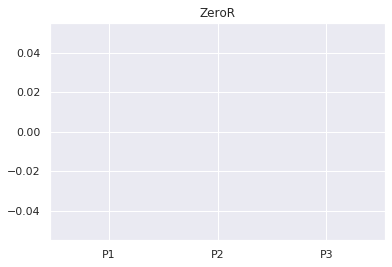

In [288]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_zeror, color='blue')
ax.set_title("ZeroR")

Text(0.5, 1.0, 'SVM')

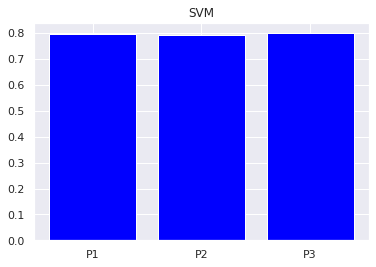

In [289]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_svm, color='blue')
ax.set_title("SVM")

Text(0.5, 1.0, 'K-nn')

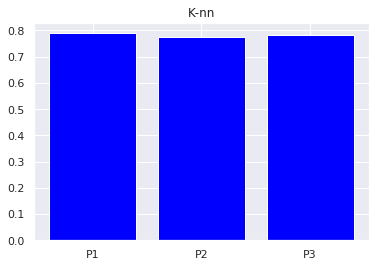

In [290]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_knn, color='blue')
ax.set_title("K-nn")

Text(0.5, 1.0, 'Árbol de decisión')

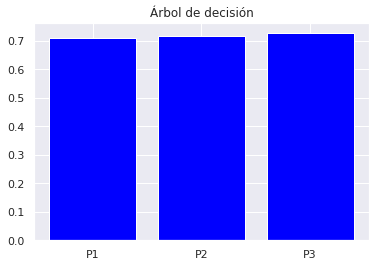

In [291]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_arbol, color='blue')
ax.set_title("Árbol de decisión")

Text(0.5, 1.0, 'MLP')

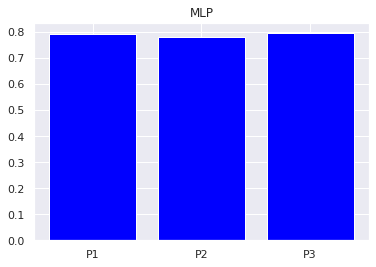

In [292]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_mlp, color='blue')
ax.set_title("MLP")

Text(0.5, 1.0, 'RF')

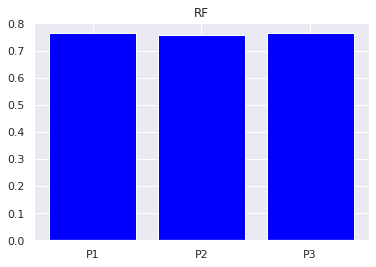

In [293]:
fig, ax = plt.subplots()
ax.bar(["P1", "P2", "P3"], v_rf, color='blue')
ax.set_title("RF")

## Modelos con hiperparámetros finales:

### ZeroR:

In [294]:
dummy_clf = DummyClassifier(strategy="most_frequent")
tn,tp, fn, fp = validacion_cruzada(dummy_clf, data, target, 5)

### SVM:

In [295]:
svm_clf = LinearSVC(random_state=15, tol=1e-5)
tn,tp, fn, fp = validacion_cruzada(svm_clf, data, target, 5)

### k-nn:

In [296]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
tn,tp, fn, fp = validacion_cruzada(knn_clf, data, target, 5)

### Árbol de decisión

In [297]:
tree_clf = DecisionTreeClassifier(random_state=15, ccp_alpha=0.003)
tn,tp, fn, fp = validacion_cruzada(tree_clf, data, target, 5)

### Multilayer Peerceptron (MLP):

In [298]:
mlp_clf = MLPClassifier(random_state=15, hidden_layer_sizes=(150,150),activation='tanh',max_iter=800,early_stopping=True)
tn,tp, fn, fp = validacion_cruzada(mlp_clf, data, target, 5)

### Random Forest (RF):

In [299]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=160, criterion = "entropy", ccp_alpha= 0.008)
tn,tp, fn, fp = validacion_cruzada(rf_clf, data, target, 5)

## Curva Roc:

In [300]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

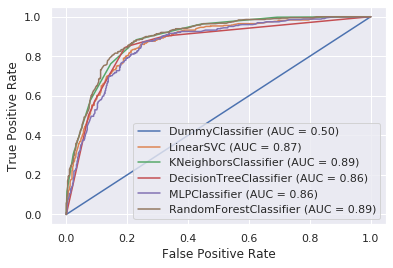

In [301]:
ax = plt.gca()

for model in [dummy_clf, svm_clf, knn_clf, tree_clf, mlp_clf, rf_clf]:
    metrics.plot_roc_curve(model, data, target, ax=ax)  

## Análisis de atributos

In [302]:
sns.set_theme()

In [303]:
datos = pd.read_csv("mamografias.csv", na_values=["?"]) # Leemos los datos del csv
# Creamos un objeto Labelencoder
le = preprocessing.LabelEncoder()
# Convertimos las columnas categóricas en numéricas
encoded_value = le.fit_transform(["R","O","L","I", "N"])

print(encoded_value)

for col in ['Shape']:
    datos[col] = le.fit_transform(datos[col])
    
datos.head()

[4 3 1 0 2]


,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,1,5.0,3.0,maligno
1,4.0,43.0,4,1.0,NaN,maligno
2,5.0,58.0,0,5.0,3.0,maligno
3,4.0,28.0,4,1.0,3.0,benigno
4,5.0,74.0,4,5.0,NaN,maligno


Visualizamos los diagramas de cajas de los atributos que poseen un orden entre sus diferentes valores dependiendo de si su etiqueta es maligno o benigno. Así tenemos una idea de la distribución de los datos según su etiqueta.

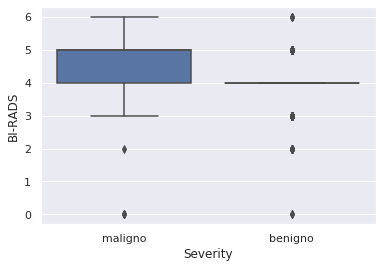

In [304]:
sns.boxplot(data=datos, y='BI-RADS', x='Severity')

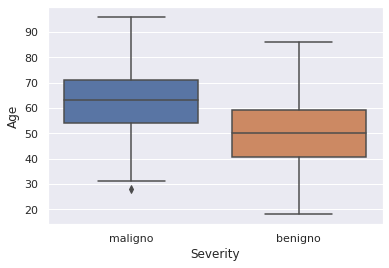

In [305]:
sns.boxplot(data=datos, y='Age', x='Severity')

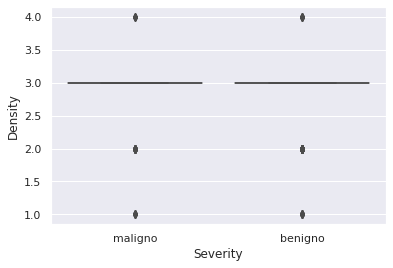

In [306]:
sns.boxplot(data=datos, y='Density', x='Severity')

Representamos en dos gráficas los datos que toman cada uno de los atributos dependiendo de su etiqueta. Si ambas gráficas son similares, significa que el atributo no aporta información en la clasificación.

Text(0.5, 1.0, 'Benignos')

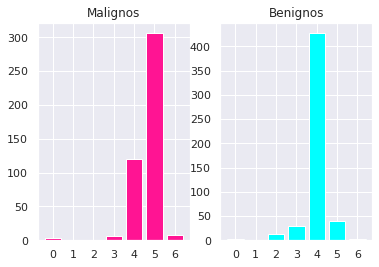

In [307]:
# Vectores con la suma de elementos dque tiene cada valor de BI-RADS.
malignos=[0,0,0,0,0,0,0]
benignos=[0,0,0,0,0,0,0]

for i in range(len(datos)):
    if not m.isnan(datos['BI-RADS'][i]):
        if datos['Severity'][i]=='maligno':
            malignos[int(datos['BI-RADS'][i])]+=1
        else:
            benignos[int(datos['BI-RADS'][i])]+=1
        
# Visualizar la gráfica
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(["0", "1", "2", "3", "4", "5", "6"], malignos, color='deeppink')
ax2.bar(["0", "1", "2", "3", "4", "5", "6"], benignos, color='aqua')
ax1.set_title("Malignos")
ax2.set_title("Benignos")

La edad máxima es: 96.0
La edad mínima es: 18.0
Diferencia de edades: 78.0


Text(0.5, 1.0, 'Benignos')

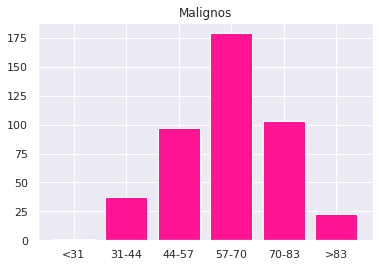

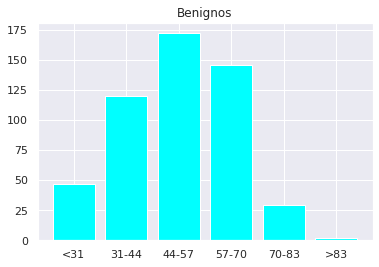

In [308]:
print("La edad máxima es: " + str(max(datos['Age'])))
print("La edad mínima es: " + str(min(datos['Age'])))
print("Diferencia de edades: " + str(max(datos['Age'])-min(datos['Age'])))
# Como 78 es múltiplo de 6, tomaré 6 conjuntos

# Vectores con la suma de elementos dque tiene cada valor de Age.
malignos=[0,0,0,0,0,0]
benignos=[0,0,0,0,0,0]

for i in range(len(datos)):
    if not m.isnan(datos['Age'][i]):
        if datos['Severity'][i]=='maligno':
            if datos['Age'][i]<31:
                malignos[0]+=1
            elif datos['Age'][i]<44:
                malignos[1]+=1
            elif datos['Age'][i]<57:
                malignos[2]+=1
            elif datos['Age'][i]<70:
                malignos[3]+=1
            elif datos['Age'][i]<83:
                malignos[4]+=1
            else:
                malignos[5]+=1
        elif datos['Age'][i]<31:
            benignos[0]+=1
        elif datos['Age'][i]<44:
            benignos[1]+=1
        elif datos['Age'][i]<57:
            benignos[2]+=1
        elif datos['Age'][i]<70:
            benignos[3]+=1
        elif datos['Age'][i]<83:
            benignos[4]+=1
        else:
            benignos[5]+=1

fig, ax1 = plt.subplots()
ax1.bar(["<31", "31-44", "44-57", "57-70", "70-83", ">83"], malignos, color='deeppink')
ax1.set_title("Malignos")

fig, ax2 = plt.subplots()
ax2.bar(["<31", "31-44", "44-57", "57-70", "70-83", ">83"], benignos, color='aqua')
ax2.set_title("Benignos")

Text(0.5, 1.0, 'Benignos')

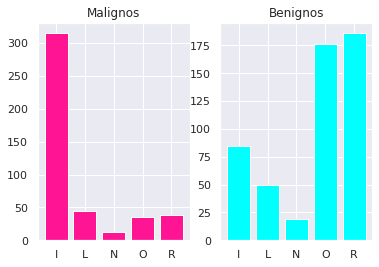

In [309]:
# Vectores con la suma de elementos dque tiene cada valor de Shape
malignos=[0,0,0,0,0]
benignos=[0,0,0,0,0]

for i in range(len(datos)):
    if not m.isnan(datos['Shape'][i]):
        if datos['Severity'][i]=='maligno':
            malignos[int(datos['Shape'][i])]+=1
        else:
            benignos[int(datos['Shape'][i])]+=1  

# Visualizar la gráfica
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(["I", "L", "N", "O", "R"], malignos, color='deeppink')
ax2.bar(["I", "L", "N", "O", "R"], benignos, color='aqua')
ax1.set_title("Malignos")
ax2.set_title("Benignos")

Text(0.5, 1.0, 'Benignos')

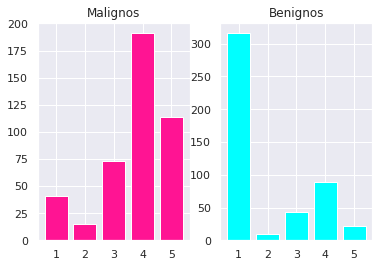

In [310]:
# Vectores con la suma de elementos dque tiene cada valor de Margin
malignos=[0,0,0,0,0]
benignos=[0,0,0,0,0]

for i in range(len(datos)):
    if not m.isnan(datos['Margin'][i]):
        if datos['Severity'][i]=='maligno':
            malignos[int(datos['Margin'][i])-1]+=1
        else:
            benignos[int(datos['Margin'][i])-1]+=1  

# Visualizar la gráfica
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(["1", "2", "3", "4", "5"], malignos, color='deeppink')
ax2.bar(["1", "2", "3", "4", "5"], benignos, color='aqua')
ax1.set_title("Malignos")
ax2.set_title("Benignos")

Text(0.5, 1.0, 'Benignos')

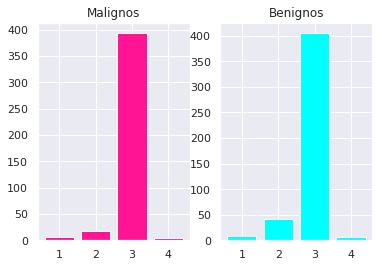

In [311]:
# Vectores con la suma de elementos dque tiene cada valor de Density
malignos=[0,0,0,0]
benignos=[0,0,0,0]

for i in range(len(datos)):
    if not m.isnan(datos['Density'][i]):
        if datos['Severity'][i]=='maligno':
            malignos[int(datos['Density'][i])-1]+=1
        else:
            benignos[int(datos['Density'][i])-1]+=1  

# Visualizar la gráfica
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(["1", "2", "3", "4"], malignos, color='deeppink')
ax2.bar(["1", "2", "3", "4"], benignos, color='aqua')
ax1.set_title("Malignos")
ax2.set_title("Benignos")